# Week 3. Recurrent Neural Networks for Time Series

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Utilities

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate the synthetic data

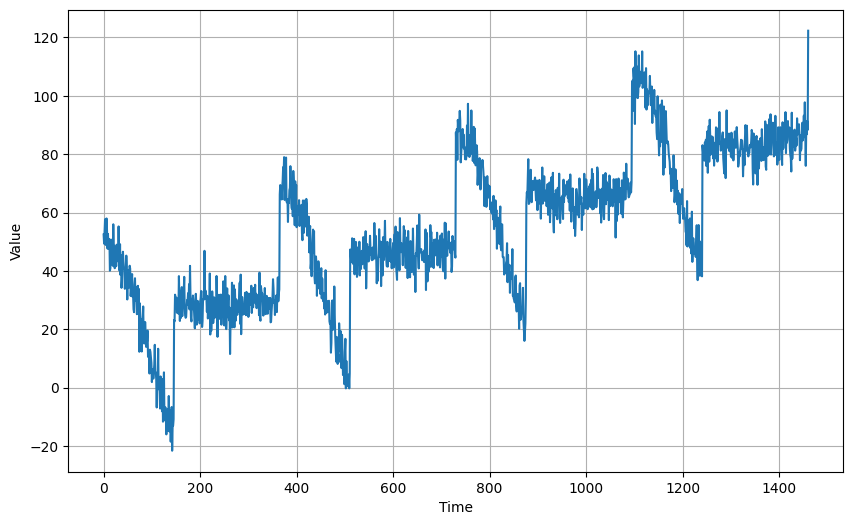

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
slope = 0.05
amplitude = 40
period = 365
noise_level = 5
seed = 42

series = baseline + seasonality(time, period, amplitude) + trend(time, slope)

series += noise(time, noise_level, seed)

plot_series(time, series)

### Split the data

In [ ]:
TIME_SPLIT = 1000

time_train = time[:TIME_SPLIT]
series_train = series[:TIME_SPLIT]

time_valid = time[TIME_SPLIT:]
series_valid = series[TIME_SPLIT:]

## Generate features and labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):

  # get the data
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # cerate window (+1 for label)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # flat the data
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # separate feature and label
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # shuffle the data
  dataset = dataset.shuffle(shuffle_buffer_size)

  # create batche data
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)


# Lab 1: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Build RNN model

we use RNN layer, but RNN only receive input with three dimension (batch, timesteps, features). So we need lambda layers to reshape input

In [ ]:
# input shape equals the number of fetaures /X value to train
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),     # output layer in time series
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_14 (Lambda)          (None, 20, 1)             0         
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 20, 40)            1680      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
 lambda_15 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(momentum=0.9))

## Optimize learning rate

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

In [ ]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 41ms/step - loss: 201.4058 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 2s 64ms/step - loss: 198.7959 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 33ms/step - loss: 195.7157 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 192.3277 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 34ms/step - loss: 188.6064 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 33ms/step - loss: 184.4853 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 37ms/step - loss: 179.9021 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 174.7778 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 33ms/step - loss: 169.0027 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 32ms/step - loss: 162.4805 - lr: 2.8184e-08

(1e-08, 0.001, 0.0, 50.0)

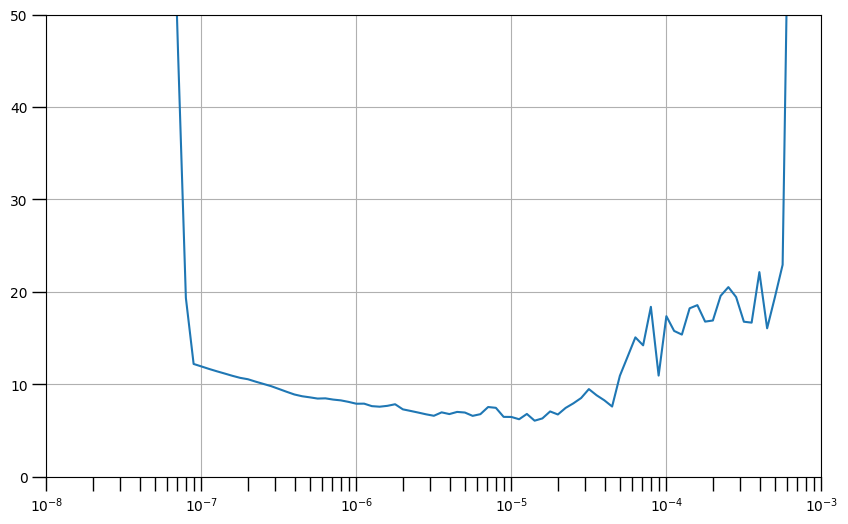

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the model

In [ ]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x* 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

# use huber to less sensitive with outliers
model_tune.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=['mae'])

In [ ]:
model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 32ms/step - loss: 81.2725 - mae: 81.7712
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 14.4879 - mae: 14.9766
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 10.9702 - mae: 11.4563
Epoch 4/100
31/31 [==============================] - 2s 77ms/step - loss: 9.6520 - mae: 10.1384
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 9.1251 - mae: 9.6095
Epoch 6/100
31/31 [==============================] - 1s 35ms/step - loss: 8.5983 - mae: 9.0819
Epoch 7/100
31/31 [==============================] - 2s 68ms/step - loss: 8.2379 - mae: 8.7186
Epoch 8/100
31/31 [==============================] - 1s 34ms/step - loss: 7.9004 - mae: 8.3856
Epoch 9/100
31/31 [==============================] - 1s 37ms/step - loss: 7.8147 - mae: 8.2968
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 7.9769 - mae: 8.4563
Epoch 11/100
31/31 [======================

## Model Prediction

### use for loop

1/1 [==============================] - 0s 24ms/step


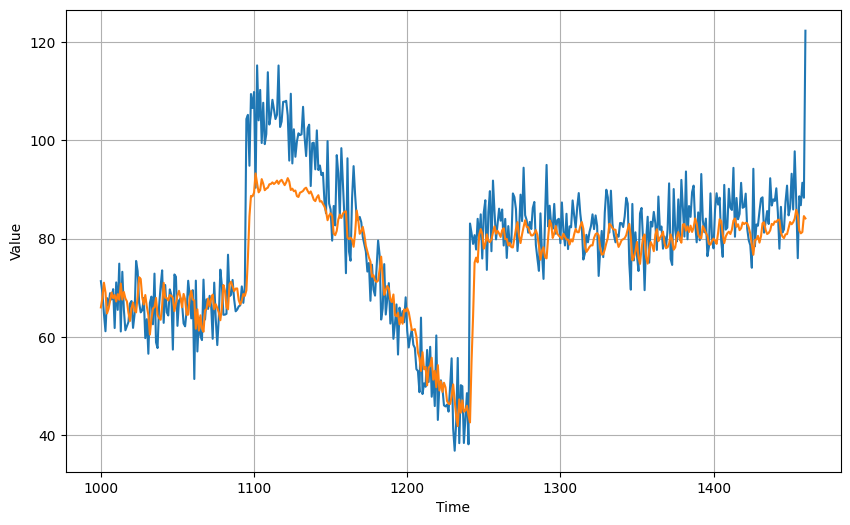

In [ ]:
forecast = []

forecast_series = series[TIME_SPLIT - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time: time+window_size][np.newaxis]))

results = np.array(forecast).squeeze()

plot_series(time_valid, (series_valid, results))

### use tf method

In [ ]:
def model_forecast(series, window_size, batch_size, model):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # just window as window_size bcs it treats only features to make prediction
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)

  forecast = model.predict(dataset)

  return forecast


15/15 [==============================] - 0s 8ms/step


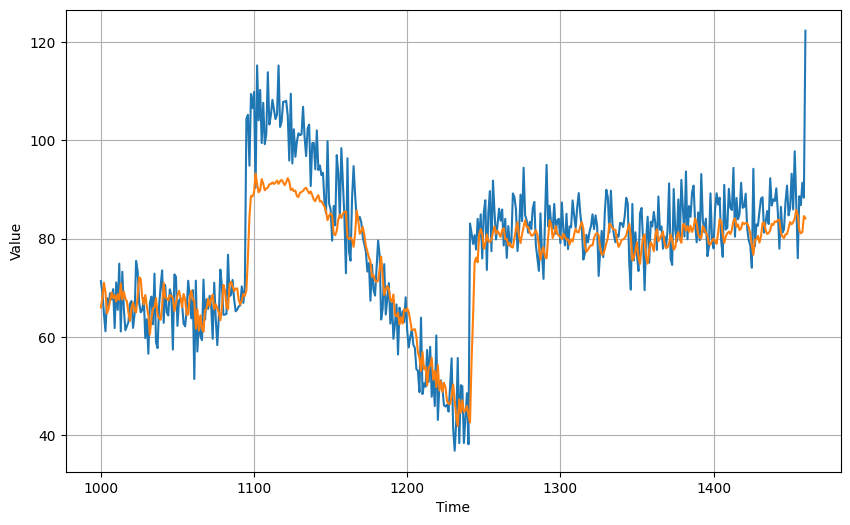

In [ ]:
forecast_series = series[TIME_SPLIT - window_size : -1]

results = model_forecast(forecast_series, window_size, batch_size, model_tune)

results = np.array(results).squeeze()

plot_series(time_valid, (series_valid, results))

In [ ]:
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

64.57674
5.9281654


# Lab 2: Using a multi-layer LSTM for forecasting

## Build the model

In [ ]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 20, 64)            8704      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

## Tune the model

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch/20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 8s 19ms/step - loss: 11.1768 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1687 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1592 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1486 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1370 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1237 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 11.1092 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 11.0933 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 11.0754 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 11.0554 - lr: 2.8184e-08
Epoch 11/100
31/3

(1e-08, 0.001, 0.0, 30.0)

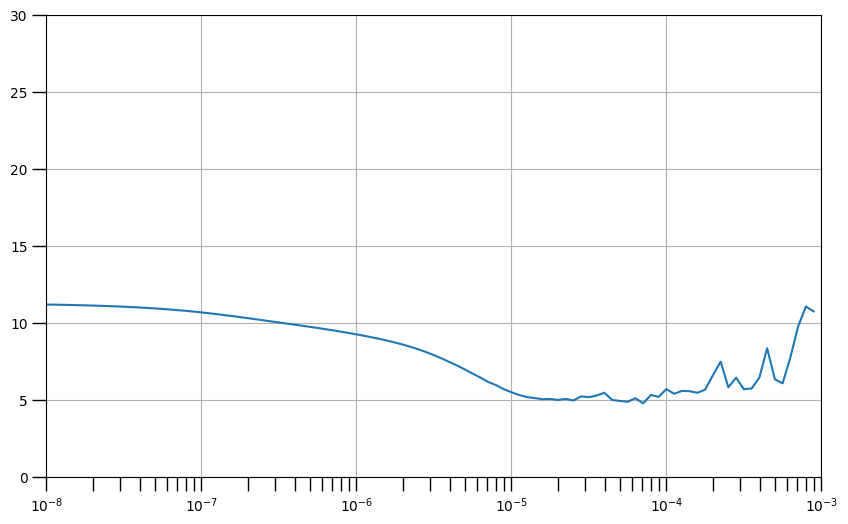

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

(1e-08, 0.0001, 0.0, 30.0)

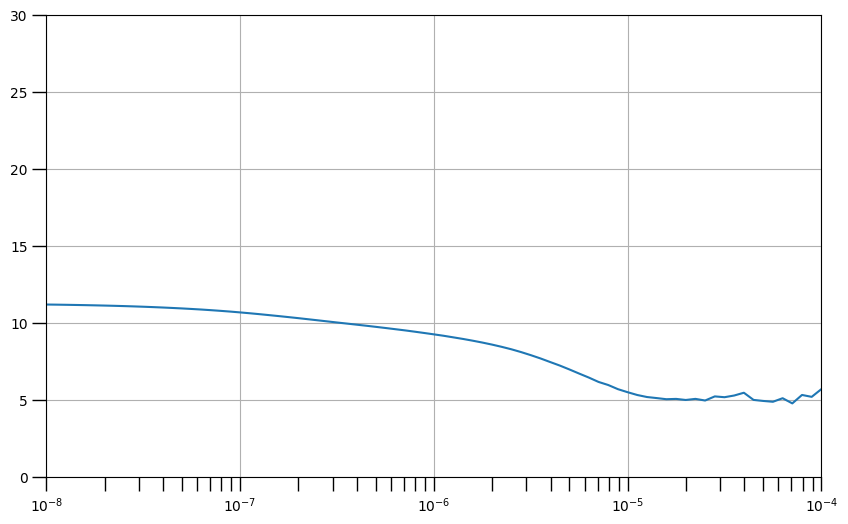

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-4, 0, 30])

## Rebuild the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 7s 11ms/step - loss: 8.9734 - mae: 9.4610
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 5.8565 - mae: 6.3365
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 5.7443 - mae: 6.2263
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 5.9802 - mae: 6.4611
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 5.8753 - mae: 6.3588
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 5.6701 - mae: 6.1532
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 5.1186 - mae: 5.5988
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 5.1546 - mae: 5.6356
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 5.4450 - mae: 5.9264
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 4.9821 - mae: 5.4607
Epoch 11/100
31/31 [=============================

## Model prediction

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 13ms/step


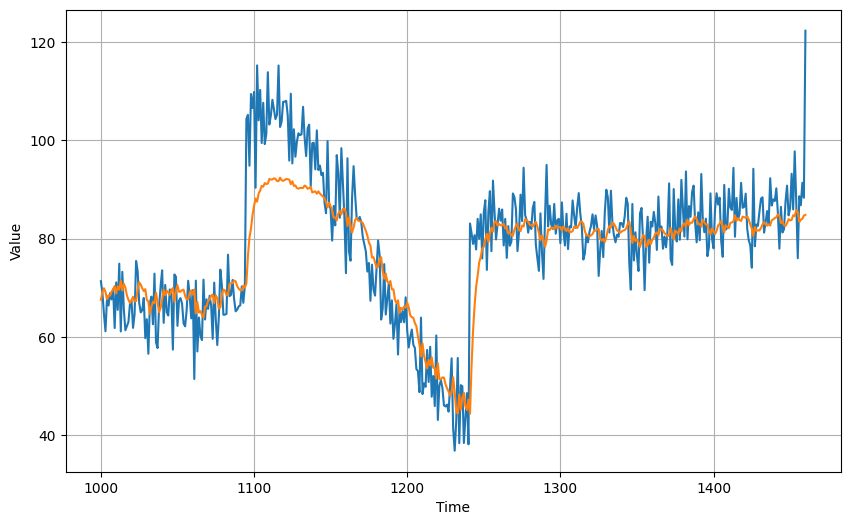

In [ ]:
# Reduce the original series
forecast_series = series[TIME_SPLIT-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

62.570923
5.7812448


## Optional: Using Data Validation

In [ ]:
data_valid = windowed_dataset(series_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

model.fit(dataset, epochs=100, validation_data=data_valid)

Epoch 1/100
31/31 [==============================] - 10s 86ms/step - loss: 19.6595 - mae: 20.1536 - val_loss: 11.7037 - val_mae: 12.1982
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 8.1095 - mae: 8.5946 - val_loss: 11.3999 - val_mae: 11.8941
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 6.6983 - mae: 7.1813 - val_loss: 9.1055 - val_mae: 9.5915
Epoch 4/100
31/31 [==============================] - 1s 15ms/step - loss: 5.9367 - mae: 6.4167 - val_loss: 7.0047 - val_mae: 7.4899
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 5.6542 - mae: 6.1298 - val_loss: 6.6403 - val_mae: 7.1205
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 5.6830 - mae: 6.1621 - val_loss: 7.3488 - val_mae: 7.8324
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 5.6689 - mae: 6.1463 - val_loss: 7.7721 - val_mae: 8.2604
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - l